In [6]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

In [18]:
def get_dataloader_workers():
    return 4

def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

train_iter, test_iter = load_data_fashion_mnist(256)

In [19]:
from torch import nn

net = nn.Sequential(nn.Flatten(), nn.Linear(784, 196), nn.ReLU(), nn.Linear(196, 49), nn.ReLU(), nn.Linear(49, 10) )

loss = nn.CrossEntropyLoss(reduction='none')

trainer = torch.optim.SGD(net.parameters(), lr=0.1)

In [22]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std = .01)

net.apply(init_weights)

num_epochs = 20

In [23]:
for epoch in range(num_epochs):
    for (x, y) in train_iter:
        l = loss(net(x), y).mean()
        trainer.zero_grad()
        l.backward()
        trainer.step()
    test_loss = 0
    test_size = 0
    for (x, y) in test_iter:
        l = loss(net(x), y)
        test_loss += l.sum()
        test_size += len(l)
    print(f'epoch {epoch + 1}, loss {test_loss/test_size:f}')

epoch 1, loss 1.089093
epoch 2, loss 0.823541
epoch 3, loss 0.684004
epoch 4, loss 0.753321
epoch 5, loss 0.587934
epoch 6, loss 0.532987
epoch 7, loss 0.516099
epoch 8, loss 0.492895
epoch 9, loss 0.510990
epoch 10, loss 0.444525
epoch 11, loss 0.468558
epoch 12, loss 0.466095
epoch 13, loss 0.460725
epoch 14, loss 0.422324
epoch 15, loss 0.426085
epoch 16, loss 0.398010
epoch 17, loss 0.380473
epoch 18, loss 0.464093
epoch 19, loss 0.376299
epoch 20, loss 0.384226


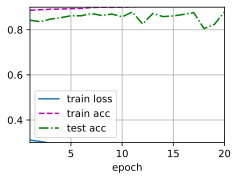

In [24]:
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

Weight Decay

In [41]:
from torch import nn

net = nn.Sequential(nn.Flatten(), nn.Linear(784, 196), nn.ReLU(), nn.Linear(196, 49), nn.ReLU(), nn.Linear(49, 10) )

loss = nn.CrossEntropyLoss(reduction='none')

wd = 0.001

params = []

for layer in net:
    if type(layer) == nn.Linear:
        params.append({"params":layer.weight,'weight_decay': wd})
        params.append({"params":layer.bias})

trainer = torch.optim.SGD(params, lr=0.1)


In [42]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std = .01)

net.apply(init_weights)

num_epochs = 20

for epoch in range(num_epochs):
    for (x, y) in train_iter:
        l = loss(net(x), y).mean()
        trainer.zero_grad()
        l.backward()
        trainer.step()
    test_loss = 0
    test_size = 0
    for (x, y) in test_iter:
        l = loss(net(x), y)
        test_loss += l.sum()
        test_size += len(l)
    print(f'epoch {epoch + 1}, loss {test_loss/test_size:f}')

epoch 1, loss 1.216988
epoch 2, loss 1.003543
epoch 3, loss 0.783124
epoch 4, loss 0.769051
epoch 5, loss 0.594893
epoch 6, loss 0.574323
epoch 7, loss 0.530786
epoch 8, loss 0.501877
epoch 9, loss 0.490722
epoch 10, loss 0.479332
epoch 11, loss 0.524213
epoch 12, loss 0.421922
epoch 13, loss 0.423050
epoch 14, loss 0.440249
epoch 15, loss 0.478097
epoch 16, loss 0.406891
epoch 17, loss 0.447976
epoch 18, loss 0.435385
epoch 19, loss 0.398213
epoch 20, loss 0.389379


Dropout

1. from scractch

In [55]:
def dropout_layer(X, dropout):
    assert 0 <= dropout < 1
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training = True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # Use dropout only when training the model
        if self.training == True:
            # Add a dropout layer after the first fully connected layer
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # Add a dropout layer after the second fully connected layer
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out

net = Net(784, 10, 196, 49)

trainer = torch.optim.SGD(net.parameters(), lr=0.1)

loss = nn.CrossEntropyLoss(reduction='none')


In [58]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std = .01)

net.apply(init_weights)

num_epochs = 20

for epoch in range(num_epochs):
    for (X, y) in train_iter:
        net.training = True
        out = net.forward(X)
        l = loss(out, y).mean()
        trainer.zero_grad()
        l.backward()
        trainer.step()
    test_loss = 0
    test_size = 0
    for (X, y) in test_iter:
        net.training = False
        out = net.forward(X)
        l = loss(out, y)
        test_loss += l.sum()
        test_size += len(l)
    print(f'epoch {epoch + 1}, loss {test_loss/test_size:f}')

epoch 1, loss 1.383855
epoch 2, loss 0.884218
epoch 3, loss 0.760334
epoch 4, loss 0.667745
epoch 5, loss 0.606167
epoch 6, loss 0.551019
epoch 7, loss 0.528095
epoch 8, loss 0.592304
epoch 9, loss 0.496690
epoch 10, loss 0.495831
epoch 11, loss 0.463609
epoch 12, loss 0.478583
epoch 13, loss 0.439642
epoch 14, loss 0.448239
epoch 15, loss 0.419703
epoch 16, loss 0.431158
epoch 17, loss 0.431723
epoch 18, loss 0.414760
epoch 19, loss 0.410157
epoch 20, loss 0.396025


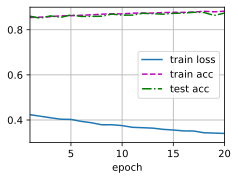

In [59]:
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

2. Pre-defined

In [62]:
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # Add a dropout layer after the first fully connected layer
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        # Add a dropout layer after the second fully connected layer
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

loss = nn.CrossEntropyLoss(reduction='none')

trainer = torch.optim.SGD(net.parameters(), lr=0.1)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=256, out_features=10, bias=True)
)

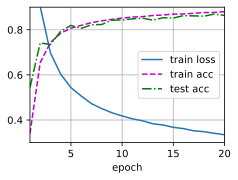

In [63]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

num_epochs = 20

d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)